In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, matthews_corrcoef, f1_score
import torch
import torch.nn as nn
import math
import copy
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
df = pd.read_csv('molecule_features.csv', sep=',')
df.rename(columns={'label':'compound'}, inplace=True)
df_PCA = pd.read_csv('/home/jovyan/scratch-shared/Viktor/CLOOME/PC.csv', sep=',')
df_PCA['PC1'] = (df_PCA['PC1'] - df_PCA['PC1'].min()) / (df_PCA['PC1'].max() - df_PCA['PC1'].min())
df_PCA['PC2'] = (df_PCA['PC2'] - df_PCA['PC2'].min()) / (df_PCA['PC2'].max() - df_PCA['PC2'].min())
#df_mor_pro = pd.read_csv('/home/jovyan/scratch-shared/Viktor/covid_batchAB_features_illumMITO_removed.csv', sep=',')

In [45]:
df_PCA.head()

,compound,PC1,PC2,smiles
0,BJ1896351,0.724928,0.341909,Fc1ccccc1-c1ccnc2OCC(=O)N(Cc3cc(cc(c3)C(F)(F)F...
1,BJ1896476,0.837748,0.421029,CCCC(C)NC(=O)c1ccc(Cl)c(Cl)c1
2,BJ1894230,0.786637,0.340443,Oc1cc2CCNCC(c3ccccc3)c2cc1O
3,BJ1896063,0.671709,0.355579,C(N1CCN(CC1)c1ncccn1)c1cnc([nH]1)-c1ccccc1
4,BJ1896111,0.672026,0.449580,Nc1nc(F)nc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H](O)[...


In [46]:
df.head()

,compound,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,BJ1897051,-0.02533,-0.000485,0.009040,-0.031100,0.001747,-0.05290,-0.010890,0.016240,0.001142,...,-0.037930,0.012920,0.023710,-0.009350,-0.034850,-0.003400,-0.004770,0.010910,0.007240,-0.03280
1,BJ1898248,0.01709,0.015180,0.015580,0.003546,-0.009710,0.01892,-0.026150,0.006830,0.005276,...,-0.014110,-0.001156,0.010350,-0.004360,-0.017990,-0.004868,0.007965,0.024490,0.016480,-0.01826
2,BJ1894725,0.04022,0.032070,0.006134,0.003940,0.023100,0.00250,0.011826,-0.042720,0.023680,...,0.037630,-0.009310,0.014740,-0.044980,0.059900,-0.002926,0.002087,0.043370,0.004265,-0.03960
3,BJ1896699,0.01474,0.014350,-0.041320,0.000897,0.031430,0.01845,-0.005722,-0.002039,0.000993,...,0.008286,0.004720,0.000343,0.003382,0.001202,0.023640,-0.019550,0.018890,0.003517,0.00461
4,BJ1898307,0.05655,0.010210,-0.011640,0.004185,-0.005950,0.01349,-0.016270,0.011696,0.037570,...,0.006960,0.000686,0.020400,-0.019790,-0.031130,-0.020220,-0.011215,0.000627,0.008330,-0.02342


In [47]:
#df_mor_pro.head()

In [48]:
df = df_PCA.merge(df, on='compound')
#df = df.merge(df_mor_pro, on='compound')

In [49]:
df.head()

,compound,PC1,PC2,smiles,0,1,2,3,4,5,...,502,503,504,505,506,507,508,509,510,511
0,BJ1896351,0.724928,0.341909,Fc1ccccc1-c1ccnc2OCC(=O)N(Cc3cc(cc(c3)C(F)(F)F...,0.037380,0.024690,0.02612,-0.013176,0.003445,0.049200,...,0.034000,-0.010680,0.007736,0.003405,0.024260,0.011086,0.030930,0.01289,0.006770,-0.02576
1,BJ1896476,0.837748,0.421029,CCCC(C)NC(=O)c1ccc(Cl)c(Cl)c1,0.021320,0.000688,-0.02788,0.011490,-0.013220,0.040560,...,-0.011250,-0.039670,-0.014720,0.020190,0.006790,0.013880,-0.003561,-0.00681,-0.004948,0.03275
2,BJ1894230,0.786637,0.340443,Oc1cc2CCNCC(c3ccccc3)c2cc1O,-0.030140,0.028060,-0.05435,-0.078000,-0.051400,0.025340,...,-0.005486,0.041900,0.057600,0.024230,0.039700,0.006016,0.020000,-0.02216,0.065860,0.00510
3,BJ1896063,0.671709,0.355579,C(N1CCN(CC1)c1ncccn1)c1cnc([nH]1)-c1ccccc1,-0.001804,0.001481,-0.01750,0.024980,0.000223,0.018720,...,0.008900,0.000376,-0.038020,0.003044,0.007465,0.008500,0.008835,-0.00998,0.014520,-0.00743
4,BJ1896111,0.672026,0.449580,Nc1nc(F)nc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H](O)[...,0.022480,0.008865,-0.02492,-0.032070,-0.016280,-0.006714,...,-0.010500,0.001236,0.006676,0.023240,0.026290,0.005380,0.013900,0.03488,-0.026520,0.03516


In [50]:
molecule_features = list(map(str, [*range(512)]))
print(molecule_features)
#morphology_profile = [*range(516,1809)]
df.loc[0,molecule_features]
#df.iloc[0, morphology_profile]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '15

0       0.03738
1       0.02469
2       0.02612
3     -0.013176
4      0.003445
         ...   
507    0.011086
508     0.03093
509     0.01289
510     0.00677
511    -0.02576
Name: 0, Length: 512, dtype: object

### Linear Regression

In [51]:
# Test linear regression on the molecule features
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,molecule_features], df['PC1'], test_size=0.2, random_state=0)
classifier = LinearRegression()
classifier.fit(X_train, y_train)
print(classifier.score(X_test, y_test)) # Calc the R2 score

-0.20129179074766657


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


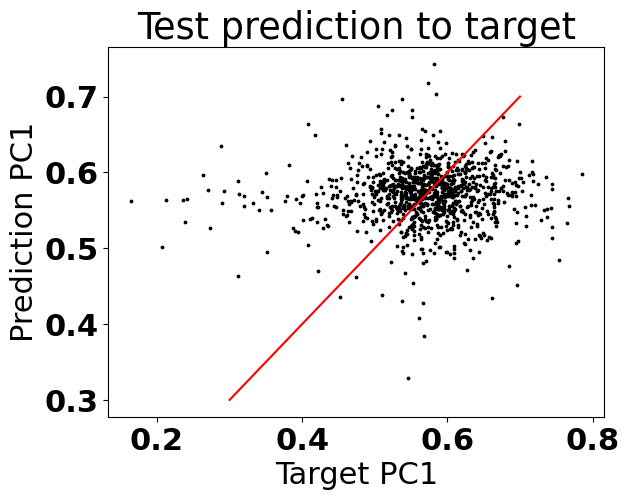

In [55]:
y_pred = classifier.predict(X_test.values)
#y_pred = classifier(torch.tensor(X_test.values, dtype=torch.float).to(device)).cpu().detach().numpy()
plt.plot([0.3, 0.7], [0.3, 0.7], c='r')
plt.scatter(y_test, y_pred, s=3, c='k')
plt.title('Test prediction to target')
plt.xlabel('Target PC1')
plt.ylabel('Prediction PC1')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


0.15815342068141625


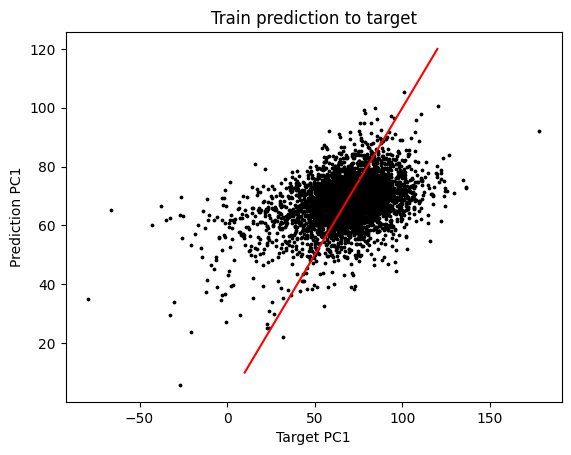

In [21]:
y_pred = classifier.predict(X_train.values)
#y_pred = classifier(torch.tensor(X_test.values, dtype=torch.float).to(device)).cpu().detach().numpy()
plt.plot([10, 120], [10, 120], c='r')
plt.scatter(y_train, y_pred, s=3, c='k')
plt.title('Train prediction to target')
plt.xlabel('Target PC1')
plt.ylabel('Prediction PC1')
print(classifier.score(X_train, y_train)) # Calc the R2 score
plt.show()

In [11]:
# Test linear regression pn the molecule features using cros validation
classifier = LinearRegression()
scores = cross_val_score(classifier, df.loc[:,molecule_features], df.loc[:,'PC1'], scoring='r2', cv=20)
print(scores)

[-0.01379516 -0.08999342 -0.12802753 -0.17325248 -0.27622375 -0.13122719
 -0.1857371  -0.16075585 -0.09600252 -0.06294667 -0.31794511 -0.4083175
 -0.27893302 -0.18187735 -0.08209609 -0.1435576  -0.12857925 -0.1408777
 -0.09132543 -0.34907248]


In [10]:
df.loc[:,molecule_features].shape

(5236, 512)

In [11]:
df.loc[:,'PC1'].shape

(5236,)

### Logistic Regression

In [22]:
# Select a cutoff

# Set cutoff value
cutoff = 25

# create a new column cutoff_{cutoff} that is 1 where PC1 < cutoff and 0 else
df.insert(2, f'cutoff_{cutoff}', df['PC1'].apply(lambda x: 1 if x < cutoff else 0))

In [23]:
df.head()

,compound,PC1,cutoff_25,PC2,smiles,0,1,2,3,4,...,502,503,504,505,506,507,508,509,510,511
0,BJ1896351,107.264143,0,-1.090375,Fc1ccccc1-c1ccnc2OCC(=O)N(Cc3cc(cc(c3)C(F)(F)F...,0.037380,0.024690,0.02612,-0.013176,0.003445,...,0.034000,-0.010680,0.007736,0.003405,0.024260,0.011086,0.030930,0.01289,0.006770,-0.02576
1,BJ1896476,136.300923,0,8.349329,CCCC(C)NC(=O)c1ccc(Cl)c(Cl)c1,0.021320,0.000688,-0.02788,0.011490,-0.013220,...,-0.011250,-0.039670,-0.014720,0.020190,0.006790,0.013880,-0.003561,-0.00681,-0.004948,0.03275
2,BJ1894230,123.146244,0,-1.265311,Oc1cc2CCNCC(c3ccccc3)c2cc1O,-0.030140,0.028060,-0.05435,-0.078000,-0.051400,...,-0.005486,0.041900,0.057600,0.024230,0.039700,0.006016,0.020000,-0.02216,0.065860,0.00510
3,BJ1896063,93.567179,0,0.540628,C(N1CCN(CC1)c1ncccn1)c1cnc([nH]1)-c1ccccc1,-0.001804,0.001481,-0.01750,0.024980,0.000223,...,0.008900,0.000376,-0.038020,0.003044,0.007465,0.008500,0.008835,-0.00998,0.014520,-0.00743
4,BJ1896111,93.648555,0,11.755774,Nc1nc(F)nc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H](O)[...,0.022480,0.008865,-0.02492,-0.032070,-0.016280,...,-0.010500,0.001236,0.006676,0.023240,0.026290,0.005380,0.013900,0.03488,-0.026520,0.03516


In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,molecule_features], df['cutoff_25'], test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.7, random_state=0)


In [16]:


X_train, X_test, y_train, y_test = train_test_split(df.loc[:,molecule_features], df['cutoff_25'], test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.7, random_state=0)

C_param_range = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7]
conf_matrixes = []

for C in C_param_range:
    print(f"Parameter C = {C}")
    classifier = LogisticRegression(random_state=0, C=C, max_iter=10000)
    classifier.fit(X_train, y_train)
    # Predict on the validation set
    y_pred = classifier.predict(X_val)
    conf_matr = confusion_matrix(y_val, y_pred)
    conf_matrixes.append(conf_matr)
    tn, fp, fn, tp = conf_matr.ravel()
    print(f"True positive: {tp}")
    #print(f"True negative: {tn}")
    #print(f"False positive: {fp}")
    #print(f"false negative: {fn}")
    

print(scores)

Parameter C = 1e-06
True positive: 0
Parameter C = 1e-05
True positive: 0
Parameter C = 0.0001
True positive: 0
Parameter C = 0.001
True positive: 0
Parameter C = 0.01
True positive: 0
Parameter C = 0.1
True positive: 0
Parameter C = 1
True positive: 0
Parameter C = 100
True positive: 2
Parameter C = 1000
True positive: 2
Parameter C = 10000
True positive: 3
Parameter C = 100000
True positive: 3
Parameter C = 1000000
True positive: 3
Parameter C = 10000000
True positive: 3
[-0.01379516 -0.08999342 -0.12802753 -0.17325248 -0.27622375 -0.13122719
 -0.1857371  -0.16075585 -0.09600252 -0.06294667 -0.31794511 -0.4083175
 -0.27893302 -0.18187735 -0.08209609 -0.1435576  -0.12857925 -0.1408777
 -0.09132543 -0.34907248]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
print(conf_matrixes)

NameError: name 'conf_matrixes' is not defined

In [18]:
for matrix in conf_matrixes:
    print(matrix)

[[501   0]
 [ 23   0]]
[[501   0]
 [ 23   0]]
[[501   0]
 [ 23   0]]
[[501   0]
 [ 23   0]]
[[501   0]
 [ 23   0]]
[[501   0]
 [ 23   0]]
[[501   0]
 [ 23   0]]
[[499   2]
 [ 21   2]]
[[492   9]
 [ 21   2]]
[[483  18]
 [ 20   3]]
[[474  27]
 [ 20   3]]
[[464  37]
 [ 20   3]]
[[462  39]
 [ 20   3]]


In [19]:
C_param_range[9]

10000

In [27]:
classifier = LogisticRegression(random_state=0, C=10000, max_iter=10000)
classifier.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

LogisticRegression(C=10000, max_iter=10000, random_state=0)

[[1485   39]
 [  43    4]]
True positive: 4
True negative: 1485
False positive: 39
false negative: 43
F1 score: 0.08888888888888888


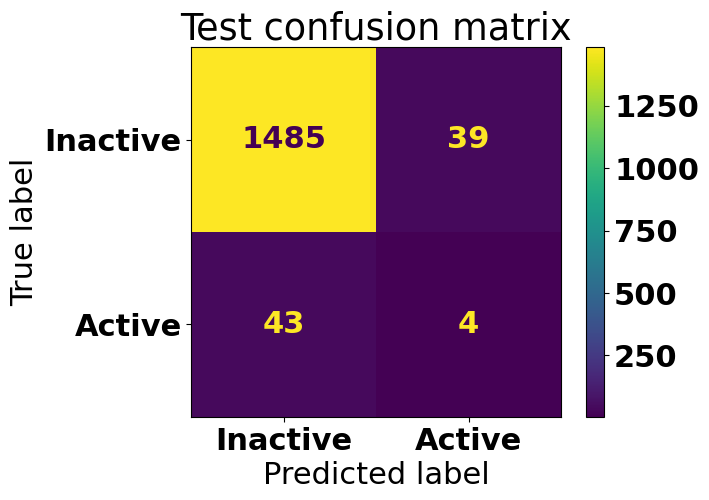

In [40]:
font = {'family': 'normal', 'weight': 'bold', 'size': 22}
y_pred = classifier.predict(X_test)
conf_matr = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=['Inactive', 'Active'])
tn, fp, fn, tp = conf_matr.ravel()
print(conf_matr)
print(f"True positive: {tp}")
print(f"True negative: {tn}")
print(f"False positive: {fp}")
print(f"false negative: {fn}")
print(f"F1 score: {f1_score(y_test, y_pred)}")
cm_display.plot()
plt.rc('font', **font)
plt.title("Test confusion matrix")
plt.show()

[[3008    8]
 [  78   47]]
True positive: 47
True negative: 3008
False positive: 8
false negative: 78
F1 score: 0.5222222222222223


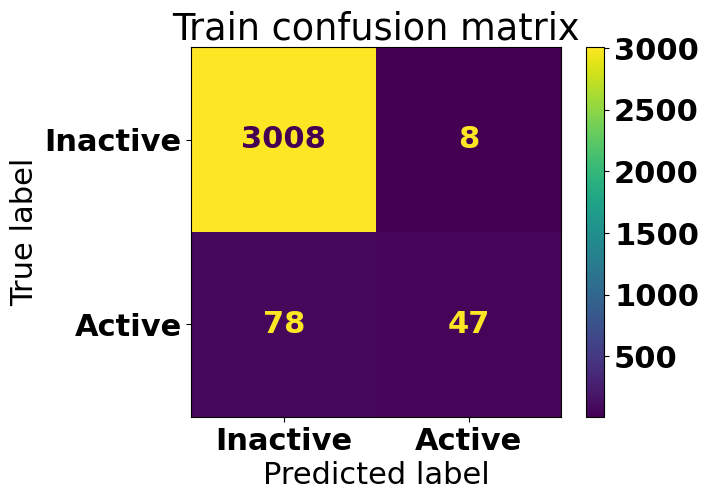

In [41]:
font = {'family': 'normal', 'weight': 'bold', 'size': 22}
y_pred = classifier.predict(X_train)
conf_matr = confusion_matrix(y_train, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=['Inactive', 'Active'])
tn, fp, fn, tp = conf_matr.ravel()
print(conf_matr)
print(f"True positive: {tp}")
print(f"True negative: {tn}")
print(f"False positive: {fp}")
print(f"false negative: {fn}")
print(f"F1 score: {f1_score(y_train, y_pred)}")
cm_display.plot()
plt.title("Train confusion matrix")
plt.rc('font', **font)
plt.show()

In [22]:
type(X_train)

pandas.core.frame.DataFrame

In [23]:
y_pred = classifier.predict(X_test)

coef_matrix = confusion_matrix(y_test, y_pred)
print(coef_matrix)

[[1485   39]
 [  43    4]]


In [24]:
tn, fp, fn, tp = coef_matrix.ravel()
print(f"True positive: {tp}")
print(f"True negative: {tn}")
print(f"False positive: {fp}")
print(f"false negative: {fn}")

True positive: 4
True negative: 1485
False positive: 39
false negative: 43


### Neural Network Regression

In [11]:
class DatasetFeature(torch.utils.data.Dataset):
    def __init__(self, X, y):
        # Take X and y from dataframes
        self.X = torch.tensor(X.values, dtype=torch.float)
        self.y = torch.tensor(y.values, dtype=torch.float)
        
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
class NNReg(nn.Module):
    def __init__(self, input_dim, h_layers, dropout, activation=nn.LeakyReLU()):
        super(NNReg, self).__init__()

        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_dim, h_layers[0])
        self.hidden_layers = nn.ModuleList()
        for index, n_nodes in enumerate(h_layers[:-1]):
            self.hidden_layers.append(nn.Linear(h_layers[index], h_layers[index+1]))
        self.fc_out = nn.Linear(h_layers[-1], 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [40]:
# Create a Neural network

# Parameters
batch_size = 32
epochs = 100

scale = df['PC1'].max()

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,molecule_features], df['PC1']/scale, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.7, random_state=0)

train = DatasetFeature(X_train, y_train)
val = DatasetFeature(X_val, y_val)
test = DatasetFeature(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(dataset=val, batch_size=val.__len__(), shuffle=False)

NN_reg_model = NNReg(input_dim=512, h_layers=[500, 500], dropout=0.05, activation=nn.LeakyReLU)
criterion = nn.MSELoss()

lr = 0.00001
weight_decay = 0.0 # l2 regression
optimizer = torch.optim.Adam(NN_reg_model.parameters(), lr=lr, weight_decay=weight_decay)

iter = 0
train_loss = []
val_loss = []
best_model = np.nan
best_loss = math.inf
loss_val = []
best_model = np.nan

for epoch in range(epochs):
    running_loss = 0.0
    NN_reg_model.train()
    NN_reg_model.to(device)
    for i, (features, PC1) in enumerate(train_dataloader):
        batch_size = features.shape[0]
        optimizer.zero_grad()
        output = NN_reg_model(features.to(device)).view([batch_size])
        loss = criterion(output, PC1.to(device))
        running_loss += loss.item() * batch_size
        loss.backward()
        optimizer.step()
        iter += 1
    # Evaluate the model on validation dataset
    NN_reg_model.eval()
    for i, (features_val, PC1_val) in enumerate(val_dataloader):
        output_val = NN_reg_model(features_val.to(device)).view(val.__len__())
        loss = criterion(output_val, PC1_val.to(device)).item()
        val_loss.append(loss)
        if loss < best_loss:
            best_loss = loss
            best_model = copy.deepcopy(NN_reg_model)
    train_loss.append(running_loss/train.__len__())
    print(f"Epoch {epoch} / {epochs}")
    print(f"Train loss: {train_loss[-1]}\tVal loss: {val_loss[-1]}")
print(f"Best val loss: {best_loss}")
    

Epoch 0 / 100
Train loss: 0.1148149589647707	Val loss: 0.09822596609592438
Epoch 1 / 100
Train loss: 0.08210586616517404	Val loss: 0.06593569368124008
Epoch 2 / 100
Train loss: 0.05009311375637242	Val loss: 0.03646333888173103
Epoch 3 / 100
Train loss: 0.025174254903184954	Val loss: 0.019687853753566742
Epoch 4 / 100
Train loss: 0.015467995110589659	Val loss: 0.01664816215634346
Epoch 5 / 100
Train loss: 0.014222370008162654	Val loss: 0.016479413956403732
Epoch 6 / 100
Train loss: 0.013999766912412127	Val loss: 0.01641402579843998
Epoch 7 / 100
Train loss: 0.013965745928849395	Val loss: 0.016356078907847404
Epoch 8 / 100
Train loss: 0.013833906002809994	Val loss: 0.016304560005664825
Epoch 9 / 100
Train loss: 0.013764446840254754	Val loss: 0.016262074932456017
Epoch 10 / 100
Train loss: 0.013675641214527813	Val loss: 0.016221949830651283
Epoch 11 / 100
Train loss: 0.013616984312780455	Val loss: 0.016190724447369576
Epoch 12 / 100
Train loss: 0.013588589580242743	Val loss: 0.01616171561

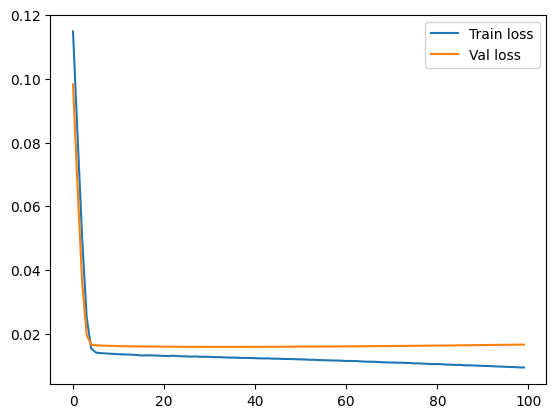

In [41]:
plt.plot(train_loss,label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.show()

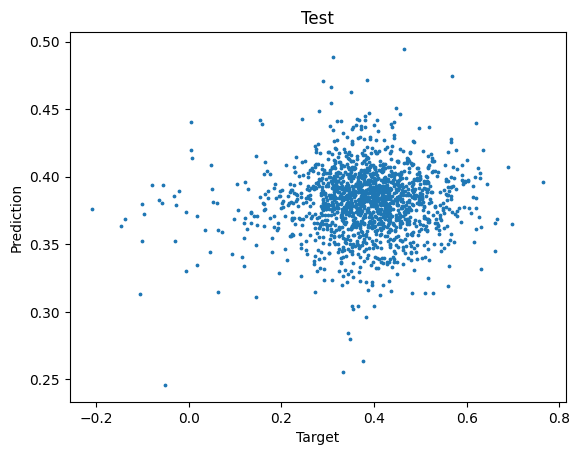

In [42]:
y_pred = best_model(torch.tensor(X_test.values, dtype=torch.float).to(device)).cpu().detach().numpy()
plt.scatter(y_test, y_pred, s=3)
plt.title('Test')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.show()

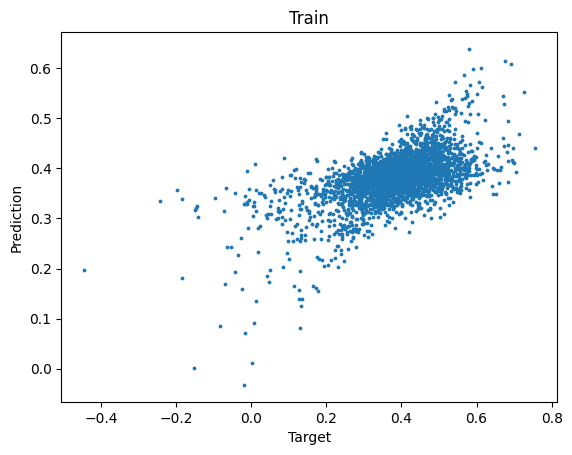

In [43]:
y_pred = NN_reg_model(torch.tensor(X_train.values, dtype=torch.float).to(device)).cpu().detach().numpy()
plt.scatter(y_train, y_pred, s=3)
plt.title('Train')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.show()

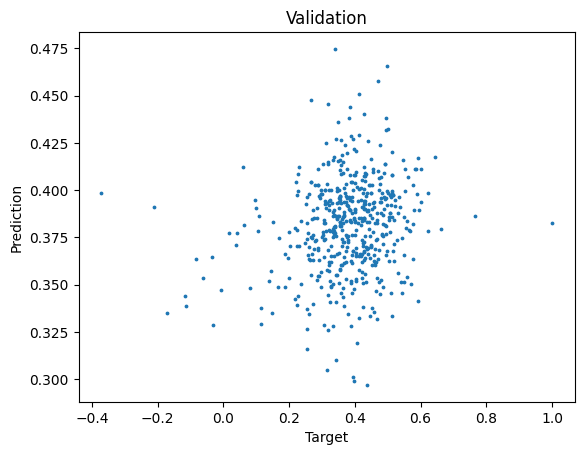

In [44]:
y_pred = best_model(torch.tensor(X_val.values, dtype=torch.float).to(device)).cpu().detach().numpy()
plt.scatter(y_val, y_pred, s=3)
plt.title('Validation')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.show()

In [18]:
df.head()

,compound,PC1,cutoff_25,PC2,smiles,0,1,2,3,4,...,502,503,504,505,506,507,508,509,510,511
0,BJ1896351,107.264143,0,-1.090375,Fc1ccccc1-c1ccnc2OCC(=O)N(Cc3cc(cc(c3)C(F)(F)F...,0.037380,0.024690,0.02612,-0.013176,0.003445,...,0.034000,-0.010680,0.007736,0.003405,0.024260,0.011086,0.030930,0.01289,0.006770,-0.02576
1,BJ1896476,136.300923,0,8.349329,CCCC(C)NC(=O)c1ccc(Cl)c(Cl)c1,0.021320,0.000688,-0.02788,0.011490,-0.013220,...,-0.011250,-0.039670,-0.014720,0.020190,0.006790,0.013880,-0.003561,-0.00681,-0.004948,0.03275
2,BJ1894230,123.146244,0,-1.265311,Oc1cc2CCNCC(c3ccccc3)c2cc1O,-0.030140,0.028060,-0.05435,-0.078000,-0.051400,...,-0.005486,0.041900,0.057600,0.024230,0.039700,0.006016,0.020000,-0.02216,0.065860,0.00510
3,BJ1896063,93.567179,0,0.540628,C(N1CCN(CC1)c1ncccn1)c1cnc([nH]1)-c1ccccc1,-0.001804,0.001481,-0.01750,0.024980,0.000223,...,0.008900,0.000376,-0.038020,0.003044,0.007465,0.008500,0.008835,-0.00998,0.014520,-0.00743
4,BJ1896111,93.648555,0,11.755774,Nc1nc(F)nc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H](O)[...,0.022480,0.008865,-0.02492,-0.032070,-0.016280,...,-0.010500,0.001236,0.006676,0.023240,0.026290,0.005380,0.013900,0.03488,-0.026520,0.03516


In [19]:
class NNClass(nn.Module):
    def __init__(self, input_dim, h_layers, dropout, activation=nn.LeakyReLU()):
        super(NNClass, self).__init__()

        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_dim, h_layers[0])
        self.hidden_layers = nn.ModuleList()
        for index, n_nodes in enumerate(h_layers[:-1]):
            self.hidden_layers.append(nn.Linear(h_layers[index], h_layers[index+1]))
        self.fc_out = nn.Linear(h_layers[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.fc_out(x)
        return self.sigmoid(x)

In [36]:
# Create a Neural network

# Parameters
batch_size = 32
epochs = 100

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,molecule_features], df['cutoff_25'], test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.7, random_state=0)

train = DatasetFeature(X_train, y_train)
val = DatasetFeature(X_val, y_val)
test = DatasetFeature(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(dataset=val, batch_size=val.__len__(), shuffle=False)

NN_class_model = NNClass(input_dim=512, h_layers=[500], dropout=0.0, activation=nn.LeakyReLU)
criterion = nn.BCELoss()

lr = 0.00001
weight_decay = 0.0 # l2 regression
optimizer = torch.optim.Adam(NN_reg_model.parameters(), lr=lr, weight_decay=weight_decay)

iter = 0
train_loss = []
val_loss = []
best_model = np.nan
best_loss = math.inf
loss_val = []
best_model = np.nan

for epoch in range(epochs):
    running_loss = 0.0
    NN_class_model.train()
    NN_class_model.to(device)
    for i, (features, PC1) in enumerate(train_dataloader):
        batch_size = features.shape[0]
        optimizer.zero_grad()
        output = NN_class_model(features.to(device)).view([batch_size])
        loss = criterion(output, PC1.to(device))
        running_loss += loss.item() * batch_size
        loss.backward()
        optimizer.step()
        iter += 1
    # Evaluate the model on validation dataset
    NN_reg_model.eval()
    for i, (features_val, PC1_val) in enumerate(val_dataloader):
        output_val = NN_class_model(features_val.to(device)).view(val.__len__())
        loss = criterion(output_val, PC1_val.to(device)).item()
        val_loss.append(loss)
        if loss < best_loss:
            best_loss = loss
            best_model = copy.deepcopy(NN_reg_model)
    train_loss.append(running_loss/train.__len__())
    print(f"Epoch {epoch} / {epochs}")
    print(f"Train loss: {train_loss[-1]}\tVal loss: {val_loss[-1]}")
print(f"Best val loss: {best_loss}")
    

Epoch 0 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 1 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 2 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 3 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 4 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 5 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 6 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 7 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 8 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 9 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 10 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 11 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 12 / 100
Train loss: 0.6948571626603395	Val loss: 0.6948471665382385
Epoch 13 / 100
Train loss: 0.694857

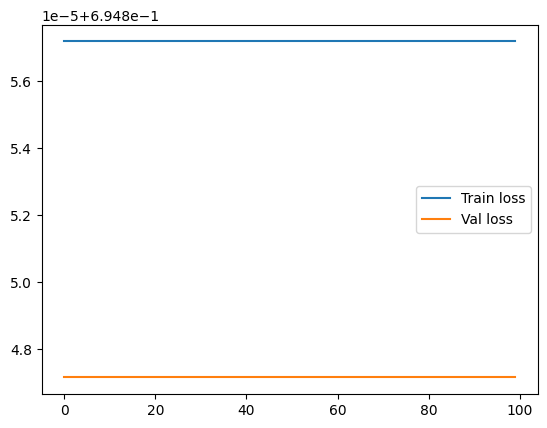

In [37]:
plt.plot(train_loss,label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.show()

In [38]:
def calc_conf_matr(idx, model, cutoff_label):
    temp = df.loc[idx, 'fingerprint'].apply(lambda finger: torch.Tensor(list(map(int, [*finger]))))
    temp = tuple(temp)
    fingerprint = torch.stack(temp).to(device)
    predictions = model(fingerprint)
    predictions = [1 if pred>0.5 else 0 for pred in predictions]
    predictions = pd.Categorical(predictions, categories=[0, 1])
    confusion_matrix = pd.crosstab(df.loc[idx, cutoff_label], predictions, dropna=False, rownames=['Class'], colnames=['Prediction'])
    return confusion_matrix

def calc_metrics(conf_matr):
    TP = conf_matr.iloc[1, 1]
    FP = conf_matr.iloc[0, 1]
    FN = conf_matr.iloc[1, 0]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)
    return precision, recall, F1

def print_res(model, label, idx, title, verbose=True):
    conf_matr = calc_conf_matr(idx, model, label)
    precision, recall, F1 = calc_metrics(conf_matr)
    if verbose:
        print(title+':')
        print(f"precision:\t{precision}")
        print(f"recall:\t{recall}")
        print(f"F1 score:\t{F1}")
        sns.set(rc={'figure.figsize':(3,2)})
        sns.heatmap(conf_matr, cmap='YlGnBu', annot=True, cbar=False)
        plt.show()
    return precision, recall, F1

In [39]:
y_pred = best_model(torch.tensor(X_test.values, dtype=torch.float).to(device)).cpu().detach().numpy()
y_pred = [1 if pred>0.5 else 0 for pred in y_pred]
y_pred = pd.Categorical(y_pred, categories=[0, 1])
confusion_matrix = pd.crosstab(y_test, y_pred)
print(confusion_matrix)

col_0         0   1
cutoff_25          
0          1505  19
1            46   1
